In [ ]:
!pip install kagglehub tensorflow keras
import kagglehub
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import os


In [ ]:
# Download the latest version of the animal image classification dataset
path = kagglehub.dataset_download("borhanitrash/animal-image-classification-dataset")
print("Path to dataset files:", path)


100%|██████████| 38.4M/38.4M [00:00<00:00, 213MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/borhanitrash/animal-image-classification-dataset/versions/1


In [ ]:
data_dir = os.path.join(path, 'Animals')
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Use ImageDataGenerator for data loading and augmentation
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,
                                   horizontal_flip=True, zoom_range=0.2, shear_range=0.1)

train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)


Found 2400 images belonging to 3 classes.
Found 600 images belonging to 3 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False  # Freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.3451 - loss: 1.2211 - val_accuracy: 0.3100 - val_loss: 1.1039
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - accuracy: 0.3583 - loss: 1.1102 - val_accuracy: 0.3467 - val_loss: 1.0964
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3716 - loss: 1.0968 - val_accuracy: 0.3333 - val_loss: 1.0913
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.3695 - loss: 1.0980 - val_accuracy: 0.3567 - val_loss: 1.0855
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.3656 - loss: 1.0890 - val_accuracy: 0.3767 - val_loss: 1.0838
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 162s 2s/step - accuracy: 0.3654 - loss: 1.0885 - val_accuracy: 0.3600 - val_loss: 1.0735
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.4161 - loss: 1.0763 - val_accuracy: 0.3767 - val_loss: 1.0722
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 152s 2s/step - accuracy: 0.4158 - loss: 1.0708 - val_accuracy: 0.4483 - v

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-6),
              loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, validation_data=validation_generator, epochs=5)


Epoch 1/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 196s 2s/step - accuracy: 0.4427 - loss: 1.5228 - val_accuracy: 0.3933 - val_loss: 1.2872
Epoch 2/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.4392 - loss: 1.3548 - val_accuracy: 0.4233 - val_loss: 1.7402
Epoch 3/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.4856 - loss: 1.1727 - val_accuracy: 0.4450 - val_loss: 2.1758
Epoch 4/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 185s 2s/step - accuracy: 0.4963 - loss: 1.0899 - val_accuracy: 0.4033 - val_loss: 2.2824
Epoch 5/5
75/75 ━━━━━━━━━━━━━━━━━━━━ 183s 2s/step - accuracy: 0.5121 - loss: 1.0320 - val_accuracy: 0.4483 - val_loss: 1.8164


In [ ]:
import numpy as np

# Get ground truth labels and predicted labels
validation_generator.reset()
y_pred = model.predict(validation_generator, verbose=1)
predicted_classes = np.argmax(y_pred, axis=1)
true_classes = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())


19/19 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step


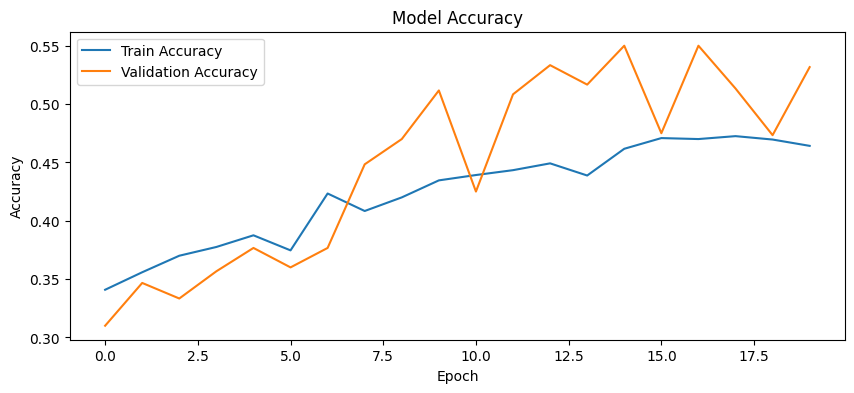

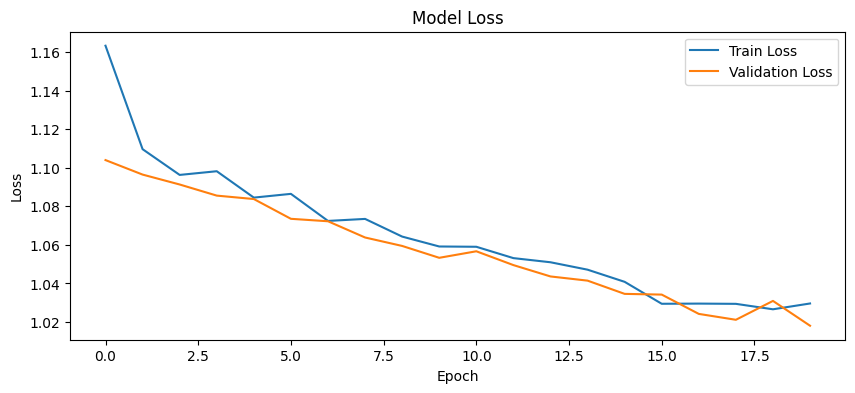

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step
              precision    recall  f1-score   support

        cats       0.00      0.00      0.00       200
        dogs       0.35      0.81      0.48       200
      snakes       0.32      0.21      0.26       200

    accuracy                           0.34       600
   macro avg       0.22      0.34      0.25       600
weighted avg       0.22      0.34      0.25       600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


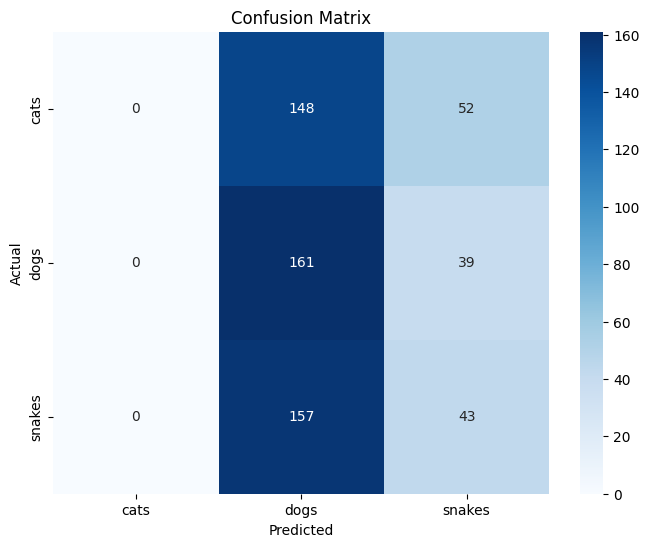

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Generate predictions
validation_generator.reset()
pred = model.predict(validation_generator, verbose=1)
predicted_class_indices = np.argmax(pred, axis=1)
true_class_indices = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())

# Classification Report
print(classification_report(true_class_indices, predicted_class_indices, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_class_indices, predicted_class_indices)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Saving sample_img1.jpg to sample_img1 (1).jpg


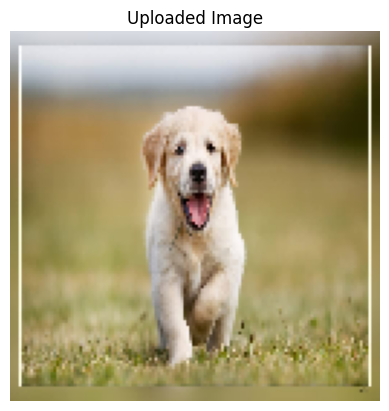

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class: dogs
Confidence: 0.9326


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload image function (opens a file upload dialog in Colab)
def upload_and_predict(model, img_size=(128, 128), class_labels=None):
    uploaded = files.upload()  # Upload the image

    for fn in uploaded.keys():
        # Load and preprocess the image
        img_path = fn
        img = image.load_img(img_path, target_size=img_size)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Uploaded Image')
        plt.show()

        x = image.img_to_array(img)
        x = x / 255.0  # rescaling as done in training
        x = np.expand_dims(x, axis=0)

        # Predict with the model
        preds = model.predict(x)
        pred_class = np.argmax(preds, axis=1)[0]
        pred_confidence = preds[0][pred_class]
        pred_label = class_labels[pred_class] if class_labels else str(pred_class)

        print(f"Predicted Class: {pred_label}")
        print(f"Confidence: {pred_confidence:.4f}")

# Assuming 'model' is your trained model and 'train_generator' from training step
# Get class labels from training generator
class_labels = list(train_generator.class_indices.keys())

# Run the upload and predict UI
upload_and_predict(model, img_size=(128, 128), class_labels=class_labels)


Saving sample_img3.jpg to sample_img3 (2).jpg


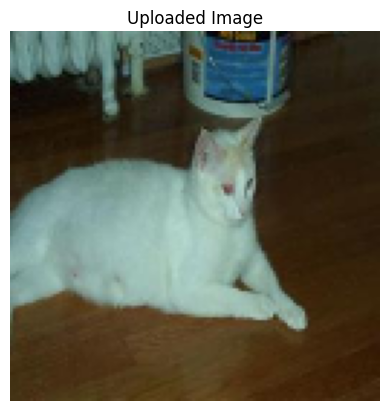

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Predicted Class: dogs
Confidence: 0.8617


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload image function (opens a file upload dialog in Colab)
def upload_and_predict(model, img_size=(128, 128), class_labels=None):
    uploaded = files.upload()  # Upload the image

    for fn in uploaded.keys():
        # Load and preprocess the image
        img_path = fn
        img = image.load_img(img_path, target_size=img_size)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Uploaded Image')
        plt.show()

        x = image.img_to_array(img)
        x = x / 255.0  # rescaling as done in training
        x = np.expand_dims(x, axis=0)

        # Predict with the model
        preds = model.predict(x)
        pred_class = np.argmax(preds, axis=1)[0]
        pred_confidence = preds[0][pred_class]
        pred_label = class_labels[pred_class] if class_labels else str(pred_class)

        print(f"Predicted Class: {pred_label}")
        print(f"Confidence: {pred_confidence:.4f}")

# Assuming 'model' is your trained model and 'train_generator' from training step
# Get class labels from training generator
class_labels = list(train_generator.class_indices.keys())

# Run the upload and predict UI
upload_and_predict(model, img_size=(128, 128), class_labels=class_labels)


Saving sample_img2.jpg to sample_img2 (6).jpg


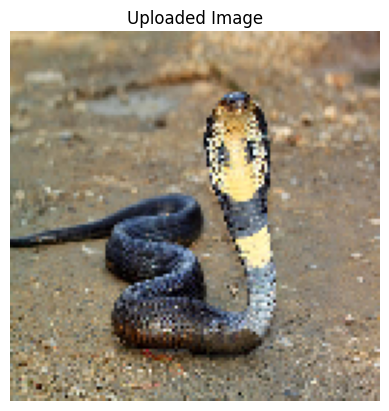

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
Predicted Class: snakes
Confidence: 0.6683


In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Upload image function (opens a file upload dialog in Colab)
def upload_and_predict(model, img_size=(128, 128), class_labels=None):
    uploaded = files.upload()  # Upload the image

    for fn in uploaded.keys():
        # Load and preprocess the image
        img_path = fn
        img = image.load_img(img_path, target_size=img_size)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Uploaded Image')
        plt.show()

        x = image.img_to_array(img)
        x = x / 255.0  # rescaling as done in training
        x = np.expand_dims(x, axis=0)

        # Predict with the model
        preds = model.predict(x)
        pred_class = np.argmax(preds, axis=1)[0]
        pred_confidence = preds[0][pred_class]
        pred_label = class_labels[pred_class] if class_labels else str(pred_class)

        print(f"Predicted Class: {pred_label}")
        print(f"Confidence: {pred_confidence:.4f}")

# Assuming 'model' is your trained model and 'train_generator' from training step
# Get class labels from training generator
class_labels = list(train_generator.class_indices.keys())

# Run the upload and predict UI
upload_and_predict(model, img_size=(128, 128), class_labels=class_labels)
